In [50]:
import pysam
import numpy as np
from scipy.signal import find_peaks
from glob import glob

mapq, firststrand = 0, True
bams = sorted(glob("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast/*.bam")); print(bams)
sams = [pysam.AlignmentFile(bam) for bam in bams]
sam = sams[0]
ref2len = {r: l for r, l in zip(sam.references, sam.lengths)}
ref, s, e, strand = "R1_81_2", 0, ref2len[ref], "+"

counts = np.zeros((len(sams), ref2len[ref]+1), dtype="int")
for fi, sam in enumerate(sams): 
    for a in sam.fetch(ref): 
        if a.mapq<mapq or a.is_secondary or a.is_supplementary: continue
        # get transcript strand (cDNA is antisense, DRS is sense)
        is_reverse = not a.is_reverse if firststrand else a.is_reverse
        if strand=="+" and is_reverse or strand=="-" and not is_reverse: continue
        # for reverse algs store the beginning of the alignment
        p = a.pos-s if is_reverse else a.aend-s
        # skip if end outside of gene body
        if p<0 or p>=counts.shape[1]: continue
        counts[fi, p] += 1
counts.sum(axis=1)

['/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast/N3PS_R10_YeastSequin_Induro1.bam', '/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast/N3PS_R10_YeastSequin_Induro2.bam', '/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast/N3PS_R9_YeastSequin_Induro.bam', '/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast/N3PS_R9_YeastSequin_TGIRT.bam']


array([1429, 1659, 5948, 1099])

In [65]:
def get_peaks(counts, prominence=5, dist=10, min_count=25):
    """Return peaks and their boundaries"""
    peaks, props = find_peaks(counts, prominence=prominence, distance=dist)
    if len(peaks)<1: return [], []
    centers, proms = [peaks[0]], [props['prominences'][0]]
    se  = [[props['left_bases'][0], props['right_bases'][0]],]
    for c, p, s, e in zip(peaks[1:], props['prominences'][1:], 
                          props['left_bases'][1:], props['right_bases'][1:]):
        if s-dist<=se[-1][-1]:
            if e>se[-1][-1]: se[-1][-1] = e
            if p>proms[-1]: centers[-1], proms[-1] = c, p
        else:
            centers.append(c)
            se.append([s, e])
    # filter by minimum number of reads
    _centers, _se = [], []
    for c, (ps, pe) in zip(centers, se):
        if counts[ps:pe].sum() < min_count: continue
        _centers.append(c)
        _se.append((ps, pe))
    centers, se = np.array(_centers), np.array(_se)
    return centers, se

centers, se = get_peaks(counts.sum(axis=0), 25); centers, se

(array([ 331,  551, 1099, 1154, 1340, 1370, 1640]),
 array([[ 317,  338],
        [ 546,  579],
        [1095, 1100],
        [1145, 1167],
        [1333, 1342],
        [1368, 1386],
        [1598, 1643]]))

In [64]:
peaks, props = find_peaks(counts.sum(axis=0), prominence=5); peaks, props

(array([ 235,  237,  253,  267,  269,  273,  279,  288,  293,  304,  306,
         309,  322,  325,  331,  337,  340,  344,  350,  353,  357,  360,
         366,  379,  382,  406,  414,  420,  423,  427,  430,  442,  445,
         459,  473,  484,  489,  491,  494,  504,  516,  527,  535,  544,
         551,  558,  568,  572,  577,  580,  584,  598,  608,  611,  628,
         632,  634,  641,  645,  662,  667,  673,  683,  695,  705,  711,
         717,  719,  735,  751,  755,  757,  761,  770,  781,  789,  795,
         812,  815,  824,  841,  844,  849,  852,  860,  880,  895,  897,
         899,  912,  915,  933,  949,  961,  975,  977,  982,  985, 1036,
        1044, 1051, 1073, 1076, 1079, 1099, 1112, 1115, 1131, 1134, 1142,
        1152, 1154, 1158, 1161, 1168, 1171, 1174, 1179, 1216, 1230, 1243,
        1291, 1296, 1299, 1301, 1323, 1336, 1340, 1346, 1348, 1367, 1370,
        1372, 1375, 1379, 1381, 1384, 1387, 1402, 1410, 1437, 1444, 1454,
        1480, 1485, 1493, 1499, 1503, 

In [59]:
find_peaks?

Signature:
find_peaks(
    x,
    height=None,
    threshold=None,
    distance=None,
    prominence=None,
    width=None,
    wlen=None,
    rel_height=0.5,
    plateau_size=None,
)
Docstring:
Find peaks inside a signal based on peak properties.

This function takes a 1-D array and finds all local maxima by
simple comparison of neighboring values. Optionally, a subset of these
peaks can be selected by specifying conditions for a peak's properties.

Parameters
----------
x : sequence
    A signal with peaks.
height : number or ndarray or sequence, optional
    Required height of peaks. Either a number, ``None``, an array matching
    `x` or a 2-element sequence of the former. The first element is
    always interpreted as the  minimal and the second, if supplied, as the
    maximal required height.
threshold : number or ndarray or sequence, optional
    Required threshold of peaks, the vertical distance to its neighboring
    samples. Either a number, ``None``, an array matching `x` or

In [1]:
import HTSeq
endsfn = "/home/lpryszcz/cluster/rna_mods/N3Pseq/transcript_ends/yeast.flt.tsv.gz.bed"
ends = HTSeq.GenomicArrayOfSets("auto", stranded=True)
for f in HTSeq.BED_Reader(endsfn): ends[f.iv] = f.name

In [78]:
usage = 0.75
rgb = ",".join(map(str, np.round(usage*np.array((255 if strand=="-" else 0, 255 if strand=="+" else 0, 0)), 0).astype('int')))
rgb

'0,191,0'

In [6]:
p = HTSeq.GenomicInterval('R1_81_2', 1651, 1652, "+")
for iv, v in ends[p].steps(): print(iv, v)

R1_81_2:[1651,1652)/+ R1_81_2|6|ext


In [7]:
iv.strand

'+'

## get_polyA_sites

Yeast Total RNA (with 4 Sequin IVT Sequences : R2_117, R2_63,  R1_103, R1_81) sequenced with R9  (Using TGIRT and Induro) and R10  (Only Induro but two reps) chemistry.
DNA Standards sequenced with R10 chemistry (Check out [this presentation](https://docs.google.com/presentation/d/1_Qo0ykExvrT1ctika1JHmOElLGYM3c0ko53zu4NtXYA/edit#slide=id.p) for the information about them)
Here is the location to the following files:
- /no_backup/enovoa/users/boguzhan/FINAL_Nano3Pseq_R10/Datasets_for_Leszek

In here you will find :
- R9_Yeast_Sequin  (R9 runs of TGIRT and Induro)
- R10  (R10 runs of Induro 2 reps and DNA standards)
- references (references used for yeast+sequin and DNA standards)

In the folders, there are three main folders:
- BAM with Move : Contains BAM files with move tables. But the mapping is not very accurate. This is just to extract the move information
- Complete BAM : This contains filtered and correctly mapped BAM files. Does not contain move table information because it went through some processing
- Complete BED: Contains Read_ID, Gene_ID information. You could probably use this to extract the reads of interest with Move table from the BAM with move

They are complete means that they are already filtered by their start location, hence all are correctly mapped reads. They should all contain, for example, polyA tailed for sequins.
On the other hand, since this is total RNA, you will find a lot of rRNAs, sn/snoRNAs, mRNAs for biological cases.

In [24]:
from collections import Counter
gtf = "/home/lpryszcz/cluster/rna_mods/ref/Saccharomyces_cerevisiae.R64-1-1.112.gtf.gz"
ann = BedTool(gtf)
genes = ann.filter(lambda x: x[2]=="gene")
c = Counter(g.attrs["gene_biotype"] for g in genes); c

Counter({'protein_coding': 6600,
         'tRNA': 299,
         'transposable_element': 91,
         'snoRNA': 77,
         'rRNA': 24,
         'ncRNA': 18,
         'pseudogene': 12,
         'snRNA': 6})

In [27]:
g.name, g.attrs

('SOR2',
 {'gene_id': 'YDL246C',
  'gene_name': 'SOR2',
  'gene_source': 'sgd',
  'gene_biotype': 'protein_coding'})

In [28]:
np.nanmean

Signature:      
np.nanmean(
    a,
    axis=None,
    dtype=None,
    out=None,
    keepdims=<no value>,
    *,
    where=<no value>,
)
Call signature:  np.nanmean(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function nanmean at 0x7f8d8c0dc9d0>
File:            ~/src/miniforge3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py
Docstring:      
Compute the arithmetic mean along the specified axis, ignoring NaNs.

Returns the average of the array elements.  The average is taken over
the flattened array by default, otherwise over the specified axis.
`float64` intermediate and return values are used for integer inputs.

For all-NaN slices, NaN is returned and a `RuntimeWarning` is raised.

.. versionadded:: 1.8.0

Parameters
----------
a : array_like
    Array containing numbers whose mean is desired. If `a` is not an
    array, a conversion is attempted.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the means are computed. Th

In [1]:
import csv, gzip, os, sys
import matplotlib.pyplot as plt, numpy as np, pysam, seaborn as sns 
from datetime import datetime
from scipy.signal import find_peaks
from pybedtools import BedTool

def get_peaks(counts, prominence=5, dist=10, min_count=25):
    """Return peaks and their boundaries"""
    peaks, props = find_peaks(counts, prominence=prominence)
    if len(peaks)<1: return [], []
    centers, proms = [peaks[0]], [props['prominences'][0]]
    se  = [[props['left_bases'][0], props['right_bases'][0]],]
    for c, p, s, e in zip(peaks[1:], props['prominences'][1:], 
                          props['left_bases'][1:], props['right_bases'][1:]):
        if s-dist<=se[-1][-1]:
            if e>se[-1][-1]: se[-1][-1] = e
            if p>proms[-1]: centers[-1], proms[-1] = c, p
        else:
            centers.append(c)
            se.append([s, e])
    # filter by minimum number of reads
    _centers, _se = [], []
    for c, (ps, pe) in zip(centers, se):
        if counts[ps:pe].sum() < min_count: continue
        _centers.append(c)
        _se.append((ps, pe))
    centers, se = np.array(_centers), np.array(_se)
    return centers, se

def get_counts(sams, ref, s, e, strand, mapq=10, firststrand=False, extend=0):
    """Return counts of read ends"""
    counts = np.zeros((len(sams), e-s+extend), dtype="int")
    for fi, sam in enumerate(sams): 
        for a in sam.fetch(ref, s, e): 
            if a.mapq<mapq or a.is_secondary or a.is_supplementary: continue
            # get transcript strand (cDNA is antisense, DRS is sense)
            is_reverse = not a.is_reverse if firststrand else a.is_reverse
            if strand=="+" and is_reverse or strand=="-" and not is_reverse: continue
            # for reverse algs store the beginning of the alignment
            p = a.pos-s+extend if is_reverse else a.aend-s
            # skip if end outside of gene body
            if p<0 or p>=counts.shape[1]: continue
            counts[fi, p] += 1
    return counts

In [3]:
from glob import glob

bampat = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/N3PS_R*.bam"
bams = sorted(glob(bampat)); bams
samples = [os.path.basename(fn)[:-4] for fn in bams]; samples
sams = [pysam.AlignmentFile(bam) for bam in bams]

In [4]:
min_count, mapq, firststrand, extend, min_frac = 5, 0, True, 1000, 0.05

gtf = "/home/lpryszcz/cluster/rna_mods/ref/yeast.gtf"
ann = BedTool(gtf)
genes = ann.filter(lambda x: x[2].endswith("gene"))
for g in genes:
    if g.name=="YIL057C": break # YAL054C YBL064C YBL030C RDN37-2 YOR383C
name, ref, s, e, strand = g.name, g.chrom, g.start, g.end, g.strand
feature = g.fields[2]
# get read ends
counts = get_counts(sams, ref, s, e, strand, mapq, firststrand, extend)
name, ref, s, e, strand, feature, counts.sum()

('YIL057C', 'chrIX', 247901, 248396, '-', 'gene', 1157)

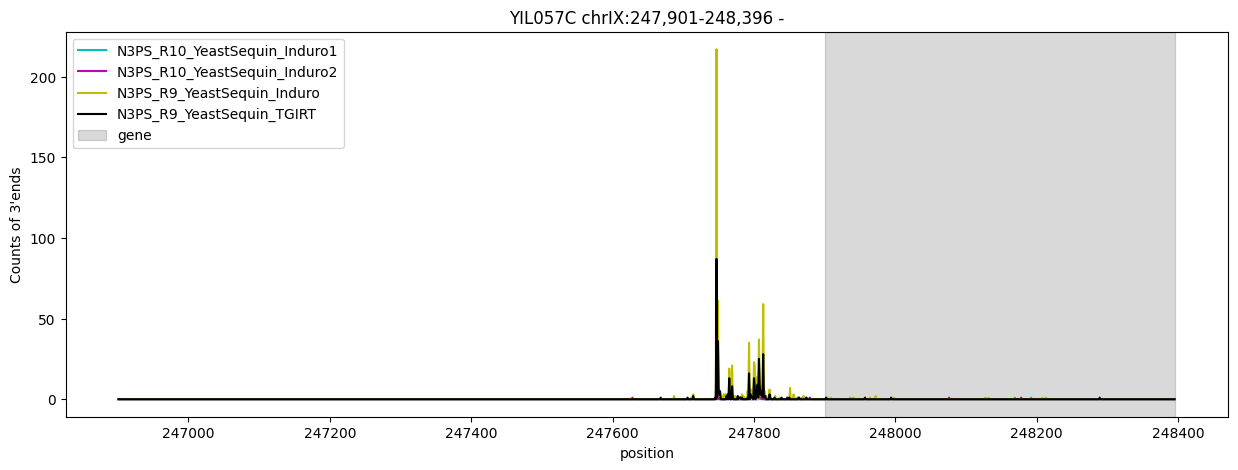

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
colors = "cmyk"
x = np.arange(s-extend, e)
for i, sample in enumerate(samples):
    ax.plot(x, counts[i], color=colors[i%len(colors)], label=sample)
ax.set_title(f"{name} {ref}:{s:,}-{e:,} {strand}")
ax.set_xlabel("position"); ax.set_ylabel("Counts of 3'ends")
ax.axvspan(s, e, *ax.get_ylim(), color="black", alpha=0.15, label="gene")
ax.legend()

In [6]:
shift = 0
centers, se = get_peaks(counts.sum(axis=0), min_count=min_count); centers, se
if not firststrand and strand=="+" or firststrand and strand=="-":
    centers, se = centers[::-1], se[::-1]
    shift = extend
centers, se

(array([950, 890, 848, 813]),
 array([[948, 951],
        [889, 924],
        [843, 871],
        [812, 814]]))

In [7]:
peak_counts = np.array([counts[:, ps:pe].sum(axis=1).flatten() for ps, pe in se]); peak_counts

array([[  0,   0,   7,   1],
       [ 31,  30, 260, 142],
       [ 46,  42, 355, 167],
       [  1,   0,   3,   2]])

In [8]:
sel = peak_counts.sum(axis=1)/peak_counts.sum(axis=1).max() >= min_frac; sel

array([False,  True,  True, False])

In [9]:
for ii, (center, (ps, pe)) in enumerate(zip(centers[sel], se[sel]), 1):
    c = counts[:, ps:pe].sum(axis=1).flatten()
    f = np.round(c/peak_counts.sum(axis=0), 3)
    print(ref, s+ps-shift, s+pe-shift, name, ii, strand, feature, s+center, *f, *c)

chrIX 247790 247825 YIL057C 1 - gene 248791 0.397 0.417 0.416 0.455 31 30 260 142
chrIX 247744 247772 YIL057C 2 - gene 248749 0.59 0.583 0.568 0.535 46 42 355 167


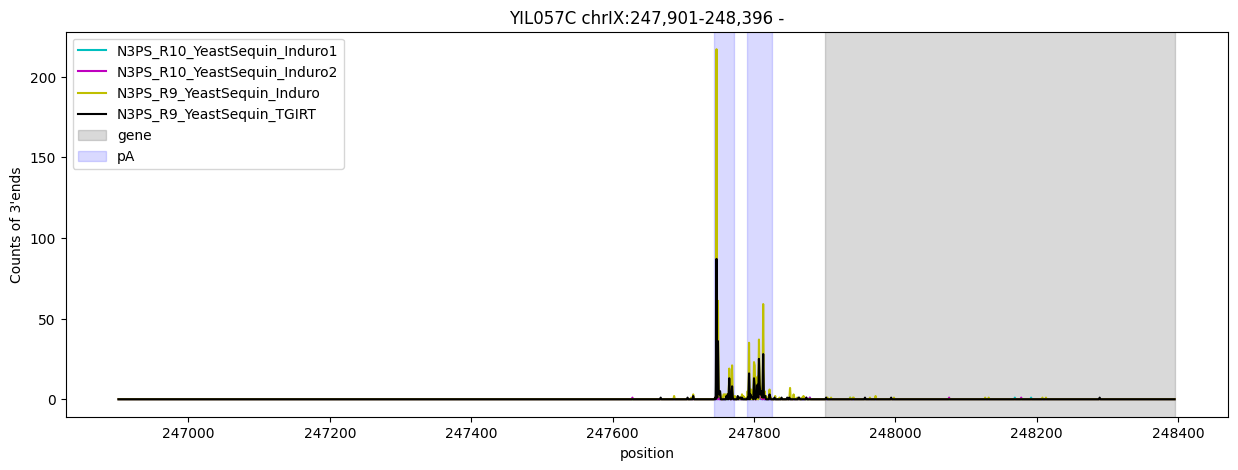

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
colors = "cmyk"
x = np.arange(s-extend, e)
for i, sample in enumerate(samples):
    ax.plot(x, counts[i], color=colors[i%len(colors)], label=sample)
ax.set_title(f"{name} {ref}:{s:,}-{e:,} {strand}")
ax.set_xlabel("position"); ax.set_ylabel("Counts of 3'ends")
ax.axvspan(s, e, *ax.get_ylim(), color="black", alpha=0.15, label="gene")
for ii, (center, (ps, pe)) in enumerate(zip(centers[sel], se[sel]), 1):
    c = counts[:, ps:pe].sum(axis=1).flatten()
    f = np.round(c/peak_counts.sum(axis=0), 3)
    ax.axvspan(s+ps-shift, s+pe-shift, *ax.get_ylim(), color="blue", alpha=0.15, label="pA" if ii<2 else "")
_ = ax.legend()

### filter

pA sites with multi-genes: 
1. skip intronic
2. and assign to the gene with fewer pA sites (or shorter if the same number of pA sites)

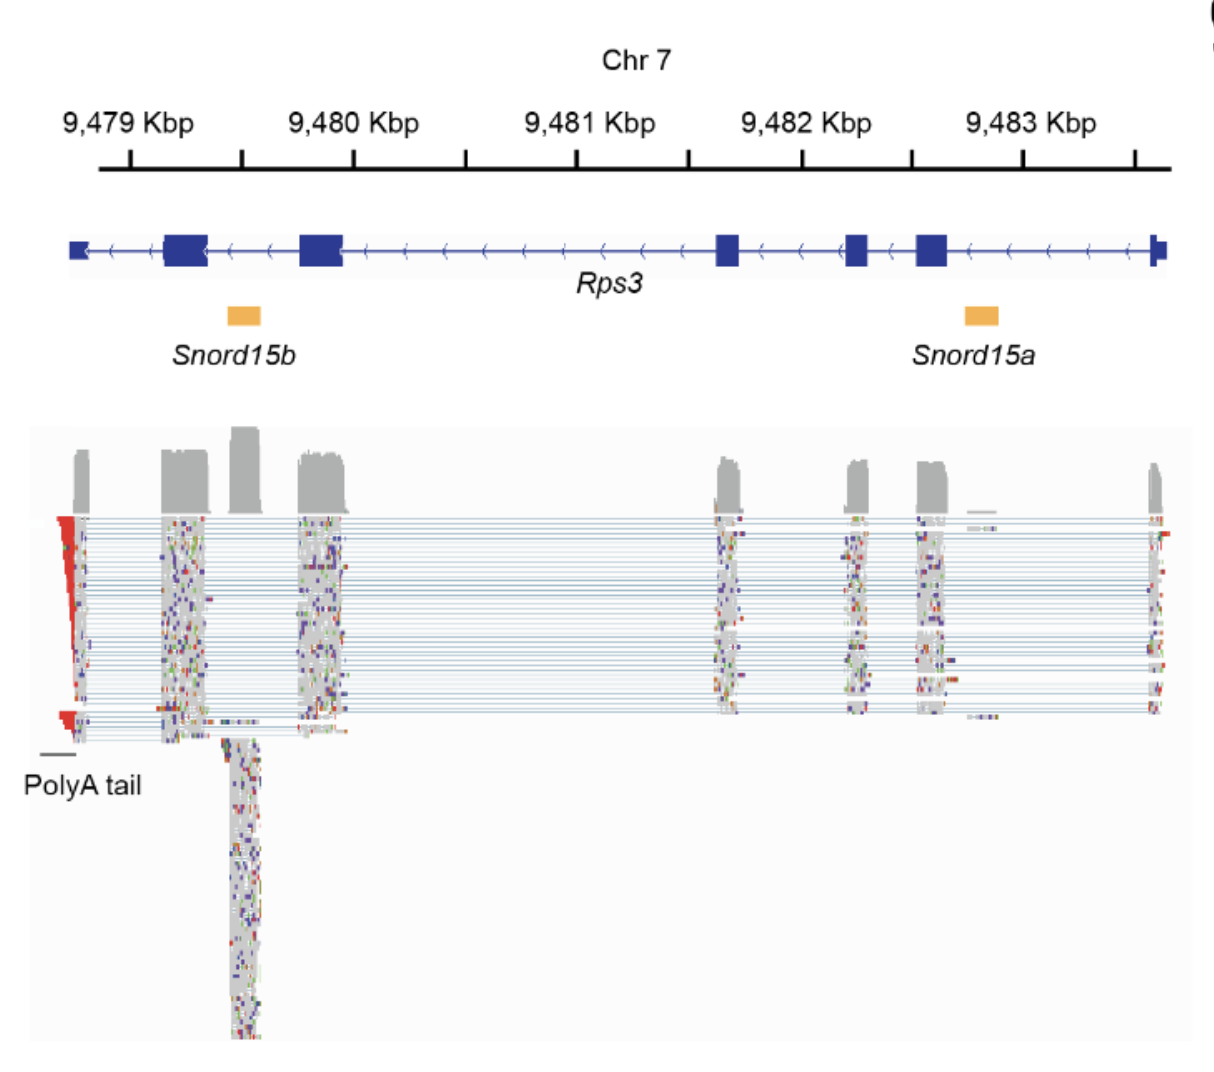

In [77]:
def report_lines(out, pos2data, gene2count, gene2len={}):
    if not pos2data: return
    for lines in pos2data.values():
        # sort by gene with lower gene2count
        lines = sorted(lines, key=lambda x: gene2count[x[0]])
        # report only 1 line for overlap
        out.write(lines[0][1])

fn = "/home/lpryszcz/cluster/rna_mods/N3Pseq/pA_sites.tsv.gz"

if fn.endswith(".gz"):
    out = gzip.open(fn[:-7]+".flt.tsv.gz", "wt")
    handle = gzip.open(fn, "rt")
else:
    out = open(fn[:-4]+".flt.tsv", "wt")
    handle = open(fn, "rt")
pchrom = ""
pos2data = {} # this can be improved using array with pointer to line list
gene2count = {}
for l in handle:
    ldata = l[:-1].split('\t')
    chrom, s, e, gene, n, strand, feature, peak_center = ldata[:8]
    if chrom!=pchrom:
        report_lines(out, pos2data, gene2count)
        pchrom = chrom
        pos2data = {}
        gene2count = {}
    k = f"{s}{strand}"
    if k in pos2data: pos2data[k].append((gene, l))
    else: pos2data[k] = [(gene, l)]
    if gene not in gene2count: gene2count[gene] = 1
    else: gene2count[gene] += 1
report_lines(out, pos2data, gene2count)
out.close(); handle.close()

In [ ]:
def load_ends(fn):
    handle = gzip.open(fn, "rt") if fn.endswith(".gz") else open(fn, "rt")
    for l in handle:
        ldata = l[:-1].split('\t')
        chrom, s, e, gene, n, strand, feature, peak_center = ldata[:8]
        if chrom not in chr2ends:
            chr2ends[chrom] = []

chr2ends = load_ends(endfn, ref2len)

In [12]:
import HTSeq
fn = "/home/lpryszcz/cluster/rna_mods/N3Pseq/pA_sites.flt.tsv.gz.bed"
ends = HTSeq.GenomicArrayOfSets("auto", stranded=True)
for f in HTSeq.BED_Reader(fn):
    ends[f.iv] = f.name
ends.chrom_vectors.keys()

FileNotFoundError: [Errno 2] No such file or directory: '/home/lpryszcz/cluster/rna_mods/N3Pseq/pA_sites.flt.tsv.gz.bed'

In [13]:
bam = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/N3PS_R10_YeastSequin_Induro2.bam"
sam = pysam.AlignmentFile(bam)
i = 0
for a in sam: 
    e = a.aend if a.is_reverse else a.pos
    p = HTSeq.GenomicInterval(a.reference_name, e-1, e, "-" if a.is_reverse else "+")
    for iv, val in ends[p].steps(): 
        if len(val): 
            print(iv, val)
            i += 1
    if i>5: break

IndexError: start too small